In [39]:
import pymongo
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

In [2]:
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [8]:
db = client.testdb
tripadvisor = db.tripadvisor
yelp = db.yelp

In [87]:
# grab from mongo, sort by date, rename index to 'order' of appearance
df = pd.DataFrame(list(yelp.find()))
df = df.drop('_id', 1)
df = df.sort_values('date').reset_index()
df.columns = ['order' if x=='index' else x for x in df.columns]
df.head()

,order,date,id,rating,text,userlocation,username
0,1550,2006-12-05,F41LRfdyzj4yagcDVsIS7g,4,"I guess the ""Tavern"" in the name refers to the...","\nFairfax, VA\n",Gayle G.
1,1782,2006-12-18,QNJmkKw9hxN74IDCNLMEkg,5,If you think this restaurant serving an Asian ...,"\nWashington, DC\n",Lydia P.
2,2038,2007-01-09,FqptloYidzdvoratrazZ0w,3,An interesting experience but nothing spectacu...,"\nToronto, Canada\n",Hratch P.
3,1783,2007-04-23,aSvpHZYUXAdCMKbnF4iyKg,5,The only restaurant in DC I give a 5-star. I h...,"\nArlington, VA\n",Haesung H.
4,1817,2007-05-21,UxpWvr2L7mzn8hY0iQDAoA,5,I loved this restaurant. The interior is beau...,"\nAlexandria, VA\n",Beth F.


In [114]:
# group by date with monthly average
df1 = df.groupby(pd.Grouper(key='date', freq='1M')).mean()
df1 = df1[['rating']]
df1.head()

,rating
date,
2006-12-31,4.5
2007-01-31,3.0
2007-02-28,NaN
2007-03-31,NaN
2007-04-30,5.0


In [115]:
# add missing values
df1 = (df1
       .resample('M')
       .mean()
       .interpolate('linear'))
df1.head()

,rating
date,
2006-12-31,4.500000
2007-01-31,3.000000
2007-02-28,3.666667
2007-03-31,4.333333
2007-04-30,5.000000


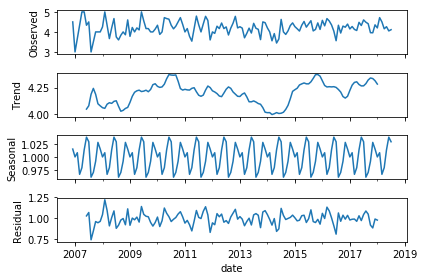

In [112]:
# decompose data
series = df1
# series = df[['date','rating']].set_index('date')
result = seasonal_decompose(series, model='multiplicative', freq=12)
result.plot()
pyplot.show()

In [116]:
df1 = df1.reset_index()
df1.head()

,date,rating
0,2006-12-31,4.500000
1,2007-01-31,3.000000
2,2007-02-28,3.666667
3,2007-03-31,4.333333
4,2007-04-30,5.000000


In [170]:
# decompose from 2011
series = df1.loc[df1['date'] > '2011-01-01'].set_index('date')
# series = df[['date','rating']].set_index('date')
result = seasonal_decompose(series, model='multiplicative', freq=12)
# result.plot()
# pyplot.show()


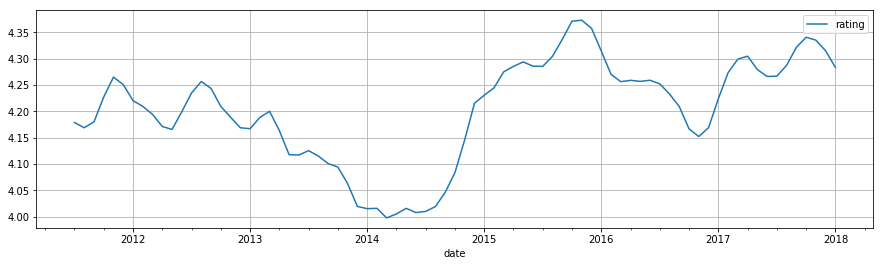

In [133]:
result.trend.plot(figsize=(15,4), grid=True)

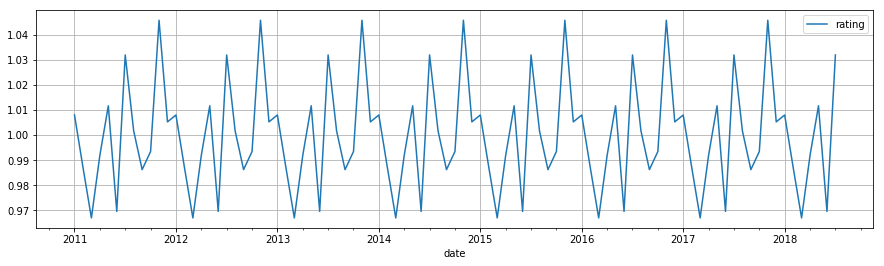

In [171]:
result.seasonal.plot(figsize=(15,4), grid=True)

In [144]:
result.seasonal.loc[result.seasonal['rating'].idxmax()]

rating    1.045786
Name: 2011-11-30 00:00:00, dtype: float64

In [145]:
result.seasonal.loc[result.seasonal['rating'].idxmin()]

rating    0.967019
Name: 2011-03-31 00:00:00, dtype: float64

In [173]:
# result.seasonal = result.seasonal.reset_index()
result.seasonal.head()

,date,rating
0,2011-01-31,1.008028
1,2011-02-28,0.987232
2,2011-03-31,0.967019
3,2011-04-30,0.991947
4,2011-05-31,1.011695


In [185]:
result.seasonal.loc[result.seasonal['rating'] > (result.seasonal.max().rating - 0.02)]

,date,rating
6,2011-07-31,1.031955
10,2011-11-30,1.045786
18,2012-07-31,1.031955
22,2012-11-30,1.045786
30,2013-07-31,1.031955
34,2013-11-30,1.045786
42,2014-07-31,1.031955
46,2014-11-30,1.045786
54,2015-07-31,1.031955
58,2015-11-30,1.045786


In [187]:
result.seasonal.loc[result.seasonal['rating'] < (result.seasonal.min().rating + 0.02) ]

,date,rating
2,2011-03-31,0.967019
5,2011-06-30,0.969606
8,2011-09-30,0.986261
14,2012-03-31,0.967019
17,2012-06-30,0.969606
20,2012-09-30,0.986261
26,2013-03-31,0.967019
29,2013-06-30,0.969606
32,2013-09-30,0.986261
38,2014-03-31,0.967019


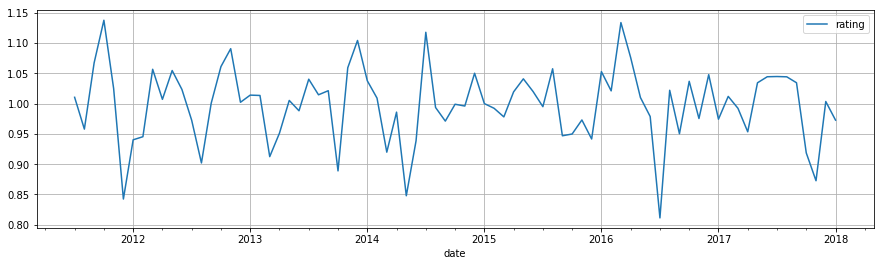

In [134]:
result.resid.plot(figsize=(15,4), grid=True)

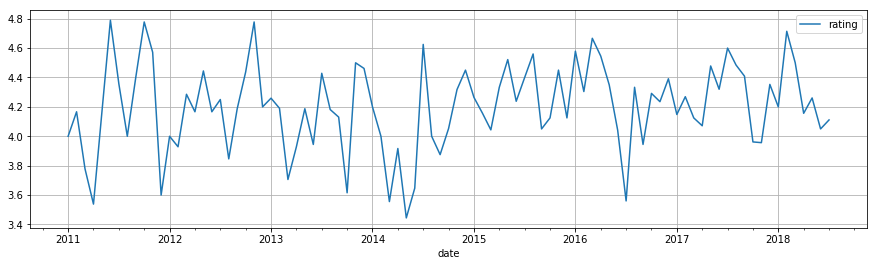

In [135]:
result.observed.plot(figsize=(15,4), grid=True)